# XAI CODE DEMO

## Explainable AI Specialization on Coursera

If you experience high latency while running this notebook, you can open it in Google Colab:

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/explainable-machine-learning/interpretable-ml/blob/main/kan_interpretability.ipynb)

# Kolmogorov-Arnold Network (KAN)

* Paper: [Liu,et.al., 2024](https://arxiv.org/pdf/2404.19756)
* KANs have no linear weights at all – every weight parameter is replaced by a univariate function parametrized as a spline
* KANs can be intuitively visualized and can easily interact with human users

#### Training a KAN:
1. Randomly initialize parameters of B-splines for each function in each layer
2. Forward pass X through the network
3. Calculate loss wrt ground truth
4. Backpropagation
5. Update B-spline parameters
6. Repeat

#### Code Demo
The original paper authors released [pykan](https://kindxiaoming.github.io/pykan/index.html), a python library for KANs. This demo is based off of the documentation provided in the library, specifically ["Getting Started with KANs"](https://kindxiaoming.github.io/pykan/intro.html#get-started-with-kans)



---






In [1]:
from kan import *
import torch

#### Initialize a KAN
* width = [2, 3, 1] - 2D input, 1D output, 5 hidden neurons
* k=3 - use cubic splines
* grid=5 - use 5 grid intervals


In [2]:
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


#### We are going to create a dataset for this code demonstration.

The output values (labels) are computed based on the function **f(x,y)**, providing a target for the KAN model to learn during training.

**f(x,y) = exp(sin(pi*x)+y^2)**

In [3]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

#### Plot KAN at initialization.
This is what our KAN looks like before training. Note the 2D input (bottom), our 5 hidden neurons (middle), and our 1D output (top)

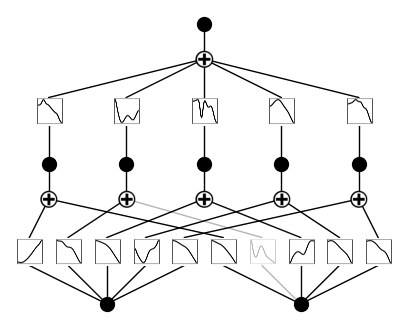

In [4]:
model(dataset['train_input']);
model.plot(beta=100)

#### Train KAN

Uses the LBFGS optimizer for 20 steps with sparsity regularization


In [5]:
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

| train_loss: 1.19e-01 | test_loss: 1.16e-01 | reg: 3.69e+01 | : 100%|█| 20/20 [01:02<00:00,  3.11s/

saving model version 0.1


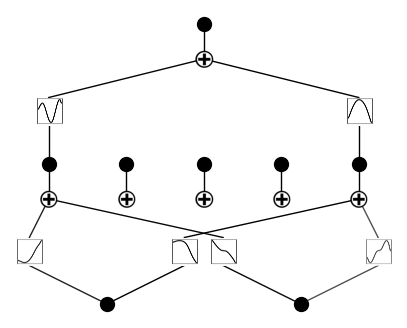

In [6]:
model.plot()

#### Prune KAN and replot (keep original shape)

saving model version 0.2


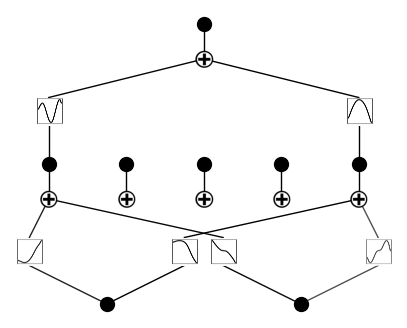

In [7]:
model.prune()
model.plot()

#### Prune KAN and replot (get a smaller shape)

saving model version 0.2


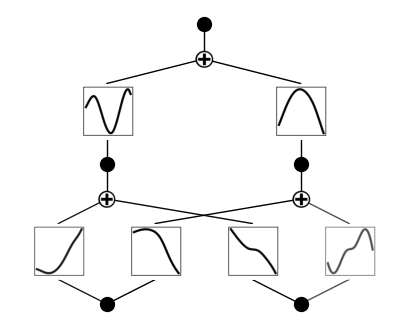

In [8]:
model = model.prune()
model(dataset['train_input'])
model.plot()

#### Continue training
Remember that KAN allows us to do continual training!

*Question: How have the splines changed after further training?*

In [9]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 8.67e-03 | test_loss: 9.22e-03 | reg: 1.83e+01 | : 100%|█| 50/50 [01:29<00:00,  1.78s/

saving model version 0.3


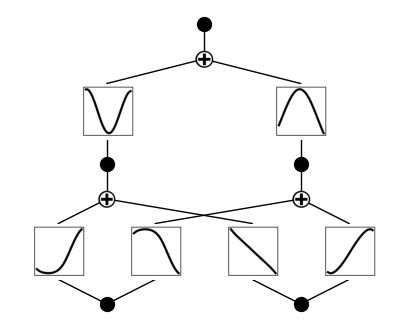

In [10]:
model.plot()

#### Set activation functions to be symbolic

We can either do this manually or automatically using the pykan library

*Try it yourself: try manual mode. How do the outputs differ from using the automated tooling?*

In [11]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9950504302978516, c=2
fixing (0,0,1) with sin, r2=0.9948008060455322, c=2
fixing (0,1,0) with x, r2=0.999693751335144, c=1
fixing (0,1,1) with sin, r2=0.999833345413208, c=2
fixing (1,0,0) with sin, r2=0.9998481869697571, c=2
fixing (1,1,0) with sin, r2=0.999969482421875, c=2
saving model version 0.4


#### Keep training!

In [12]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.65e-01 | test_loss: 1.76e-01 | reg: 0.00e+00 | : 100%|█| 50/50 [01:03<00:00,  1.27s/

saving model version 0.5


#### Get the symbolic formula

In [13]:
model.symbolic_formula()[0][0]

-5.68194723129272*sin(1.74696483381527*x_2 + 2.93015058324011*sin(1.03820717334747*x_1 - 4.19435834884644) + 0.174521114320773) - 7.60224962234497*sin(2.90553866814207*sin(1.06466197967529*x_1 - 4.17815685272217) - 0.839551379357673*sin(1.60218381881714*x_2 + 9.42545604705811) + 3.40472320332252) + 0.671763008693233